In [96]:
import numpy as np
data3d = '/home/daizj/Homeworks/gv/HW4/data3D/'
R_gt = np.array([[9.811215444923645501e-01, -1.933921273809177666e-01],
                 [1.933921273809177666e-01, 9.811215444923645501e-01]])
t_gt = np.array([[1.629147451076420561e+00],
                [5.212383419509611926e-01]])
p = np.loadtxt(data3d + 'P.txt')
q = np.loadtxt(data3d + 'Q.txt')
#down sample
print("p shape:",p.shape)
print("q shape:",q.shape)

p shape: (377, 3)
q shape: (377, 3)


In [97]:
def compute_lb(p, q, cube, threshold=1e-4):
    t = np.array([np.mean(cube[0:2]), np.mean(cube[2:4]), np.mean(cube[4:])])
    p_t = p + t
    point_distances = np.linalg.norm(p_t, axis=1) - np.linalg.norm(q, axis=1)
    lower_bound = np.sum(np.abs(point_distances) <= threshold)
    return lower_bound

def compute_ub_another(p, q, cube, threshold=1e-4):
    region_p = []
    region_q = []
    t_c = np.array([np.mean(cube[0:2]), np.mean(cube[2:4]), np.mean(cube[4:])])
    r = (cube[1]-cube[0])/2
    dist_p_t = np.linalg.norm(p + t_c, axis=1)
    region_p = [np.array([dist_p_t[i] - r, dist_p_t[i] + r]) for i in range(p.shape[0])]
    dist_q = np.linalg.norm(q, axis=1)
    region_q = [np.array([dist_q[i] - threshold, dist_q[i] + threshold]) for i in range(q.shape[0])]

    upper_bound = 0
    for i in range(len(region_q)):
        no_intersection = np.logical_or(region_q[i][0] >= region_p[i][1], region_q[i][1] <= region_p[i][0])
        if no_intersection == False:
            upper_bound = upper_bound + 1
    return upper_bound

def init_cubes(power = 4): 
    cubes = []
    radius = 0.01
    x_min = -radius 
    x_max = radius
    y_min = -radius - 0.23
    y_max = radius - 0.23
    z_min = -radius - 0.1
    z_max = radius - 0.1
    for i in range(power):
        for j in range(power):
            for k in range(power):
                step_x = (x_max-x_min)/power
                step_y = (y_max-y_min)/power
                step_z = (z_max-z_min)/power
                cube = np.array([x_min + i * step_x, x_min + (i+1) * step_x, 
                                 y_min + j * step_y, y_min + (j+1) * step_y,
                                 z_min + k * step_z, z_min + (k+1) * step_z]) 
                cubes.append(cube)
    return cubes

def split_cubes(cube, power = 2):
    cubes_sp = []
    for i in range(power):
        for j in range(power):
            for k in range(power):
                step = (cube[1] - cube[0]) / power
                cube_sp = np.array([cube[0]+i*step, cube[0]+(i+1)*step, 
                                    cube[2]+j*step, cube[2]+(j+1)*step,
                                    cube[4]+k*step, cube[4]+(k+1)*step])
                cubes_sp.append(cube_sp)
    return cubes_sp

########## test ##########
cubes = init_cubes()
print("init cubes",len(cubes))
new_cube = []
lower_bounds = []
upper_bounds = []
for i in cubes:
    lb = compute_lb(p, q, i, threshold=1e-4)
    ub = compute_ub_another(p, q, i, threshold=1e-4)
    lower_bounds.append(lb)
    upper_bounds.append(ub)
    sp_cube = split_cubes(i)
    new_cube = new_cube + sp_cube
print("new split cubes",len(new_cube))
print("lower bounds:",lower_bounds)
print("upper bounds:",upper_bounds)

init cubes 64
new split cubes 512
lower bounds: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
upper bounds: [0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 3, 4, 7, 9, 16, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 6, 9, 13, 20, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 3, 8, 7, 10, 14, 11, 1, 1, 0, 0, 1, 0, 0, 0, 1, 4, 7, 10, 8, 9, 8, 6]


In [98]:
import heapq
def bnb_search(p, q, Q_c,tolerance=1, threshold=1e-4,best_bound = 0, depth = 0):
    lower_bounds = []
    upper_bounds = []
    for c in Q_c:
        lb = compute_lb(p, q, c, threshold)
        ub = compute_ub_another(p, q, c, threshold)
        lower_bounds.append(lb)
        upper_bounds.append(ub)
    if len(Q_c)>1000:
        lb_max_index = heapq.nlargest(1000, range(len(lower_bounds)), key=lower_bounds.__getitem__)
        Q_c_cut = [Q_c[lb_max_index[i]] for i in range(len(lb_max_index))]
        lb_cut = [lower_bounds[lb_max_index[i]] for i in range(len(lb_max_index))]
        ub_cut = [upper_bounds[lb_max_index[i]] for i in range(len(lb_max_index))]
    else:
        Q_c_cut = Q_c
        lb_cut = lower_bounds
        ub_cut = upper_bounds
    max_lb = max(lb_cut)
    max_index = lb_cut.index(max_lb)
    max_cube = Q_c_cut[max_index]
    print("lb:", max(lb_cut))
    print("ub:", max(ub_cut))
    
    if ub_cut[max_index]-max_lb <= tolerance or depth == 10:
    #if depth == 10:
        print("end")
        print("ub-lb:",ub_cut[max_index]-max_lb)
        t = np.array([np.mean(max_cube[0:2]), np.mean(max_cube[2:4]), np.mean(max_cube[4:])])
        print(f't_bnb: {t}')
    else: 
        Q_c_new = []
        for i in range(len(Q_c_cut)):
            if lb_cut[i] > best_bound:
                best_bound = lb
            if ub_cut[i] > best_bound:
                Q_c_new += split_cubes(Q_c_cut[i], power = 2)
        depth = depth + 1
        print("len Q:",len(Q_c_new))
        t = bnb_search(p, q, Q_c_new, tolerance, threshold, best_bound, depth)
    return t

def compute_rotation_matrix(p, q):
    H = np.dot(q.T, p)
    U, _, Vt = np.linalg.svd(H)
    R = np.dot(U,Vt)
    return R

def registrate_2d(p, q, tolerance=1, threshold=1e-4):
    init_Q = init_cubes()
    t = bnb_search(p, q, init_Q, tolerance, threshold, best_bound = 0)
    # t = np.array([-0.00332031, -0.22597656, -0.08496094])
    p_t = p + t
    res = np.linalg.norm(q, axis=1) - (np.linalg.norm(p_t, axis=1))
    indice = np.abs(res) < 0.01
    q_t = q[indice]
    p_t = p_t[indice]
    r = compute_rotation_matrix(p_t, q_t)
    print("t:",t)
    print("r:",r)
    return r, t

r, t = registrate_2d(p, q, tolerance=0, threshold=1e-4)

lb: 2
ub: 20
len Q: 304
lb: 2
ub: 14
len Q: 1616


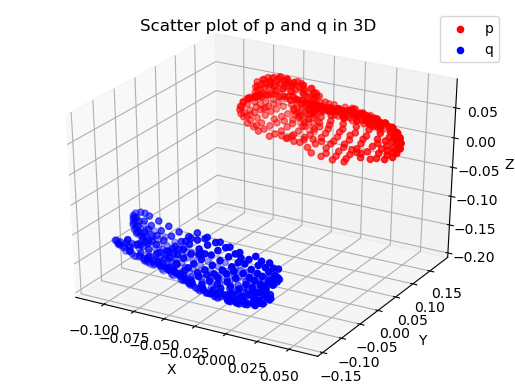

In [ ]:
import matplotlib.pyplot as plt
def visualize_3d(p,q):
    # Plotting p and q in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(p[:, 0], p[:, 1], p[:, 2], c="red", label="p")
    ax.scatter(q[:, 0], q[:, 1], q[:, 2], c="blue", label="q")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Scatter plot of p and q in 3D")
    ax.legend()
    plt.show()
visualize_3d(p,q)

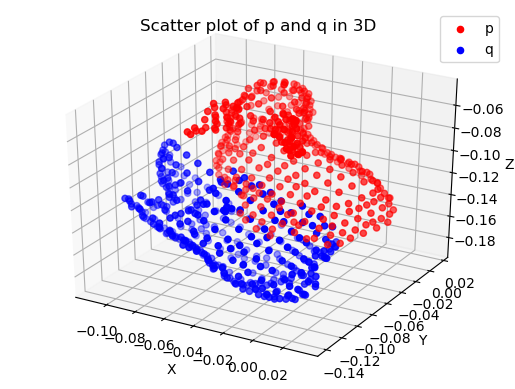

In [ ]:
p_trans = (p+t) @ r.T
visualize_3d(p_trans,q)